# url: https://qiita.com/mshinoda88/items/0e54e7e03e1aa52edb5b

※ 元記事にseed値を固定していないため再現性による検証は出来ていない

# 次元削減とクラスタリング

## 概要
主成分分析(PCA, Principal Component Analysis) をクラスター分析と組み合わせて、高次の次元で定義されたデータを2次元空間データで表現する方法を、python3 で見ていく。また、類似のグループまたはクラスタのデータを検索し、データ内に隠れた関係を見つける。

## キーワードの復習
PCAは主成分(principal component)を見つけることによってデータの次元を低下させる。
データセット元の特徴または変数を主成分に基づいて、縮小されたセットに変換することにより、データの分散を最大化するの最小の変数が得られます。
新しい変数が2つしかない場合、データ内の各サンプルを散布図などの2次元チャートで表すことができます。

## クラスタリング
教師なしデータの分析技術として、クラスタリングは、その変数に基づいて「近接したデータサンプル」を編成する。

    →各データが互いに「どのように関係しているのか」を理解し、同様のグループを発見可能。
    →このグループまたはクラスタのそれぞれを取得すると、それらの重心(centroid)を定義可能。

## 重心(centroid)
重心は、クラスタ内の各データまでの距離の合計を最小にするデータサンプル。重心変数を分析することによって、各クラスタの特性を定義可能に。

## 1. データセットの準備
感染性結核の有病率に関するデータセットを使用。TB＝Tuberculosis、結核

    ・Gapminderのウェブサイト。
    　TB estimated prevalence (existing cases) per 100K
    ・データセットは、各サンプル(国別データ)は18の異なる変数(1990年から2007年までの年別データ)。
    ・それぞれ1990年から2007年までの年間の10万人当たりの感染性結核の症例数（既存、新規、死亡）。

python 記述の前準備を行います。

In [1]:
# 基本のライブラリを読み込む
import numpy as np
import pandas as pd
from scipy import stats

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import matplotlib as mpl
mpl.rcParams['font.family'] = ['serif']

url = 'https://docs.google.com/spreadsheets/d/1X5Jp7Q8pTs3KLJ5JBWKhncVACGsg5v4xu6badNs4C7I/pub?gid=0&output=csv'
existing_df = pd.read_csv(url, index_col = 0, thousands  = ',')
existing_df.index.names = ['country']
existing_df.columns.names = ['year']
dhead = existing_df.head()
display(dhead)

year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
country,,,,,,,,,,,,,,,,,,
Afghanistan,436,429,422,415,407,397,397,387,374,373,346,326,304,308,283,267,251,238
Albania,42,40,41,42,42,43,42,44,43,42,40,34,32,32,29,29,26,22
Algeria,45,44,44,43,43,42,43,44,45,46,48,49,50,51,52,53,55,56
American Samoa,42,14,4,18,17,22,0,25,12,8,8,6,5,6,9,11,9,5
Andorra,39,37,35,33,32,30,28,23,24,22,20,20,21,18,19,18,17,19


## 2. 主成分分析による次元削減
### PCAを実行
まず、18の異なる変数(1990年から2007年までの年別データ)を各国、2次元空間で表現したい。PCAを使用することにより、これらの18の変数を、その情報を最もよく捕捉する2つの変数に減らす。

そのために、最初にPCAを実行する。
sklearn.decomposition.PCA

この実装では、特異値分解の scipy.linalg 実装を使用する。
密な配列でのみ機能し、大きな次元のデータにはスケーリングできない。

疎配列を使用している場合は numpy dense array
または sklearn.decomposition.SparsePCA
を参照。

このPCAの実装を使用する場合、使用する主成分の数を事前に指定する必要がある。
次に、fit() メソッドを呼び出し、結果を確認するだけ。



In [2]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(existing_df)

PCA(n_components=2)

## 主成分の確認
主成分はcomponents_に入っている。
ついでに平均と共分散行列はmean_, get_covariance()で見られる。

In [3]:
print("--- components ---")
display(pca.components_)

print("--- mean ---")
display(pca.mean_)

print("--- covariance ---")
display(pca.get_covariance())


--- components ---


array([[ 0.25583801,  0.25470394,  0.25141064,  0.24772801,  0.24449817,
         0.24141272,  0.2202353 ,  0.21919471,  0.2165391 ,  0.22204506,
         0.22879832,  0.23376061,  0.23077592,  0.23574534,  0.23472456,
         0.23435384,  0.23355341,  0.23217055],
       [ 0.33830021,  0.31393233,  0.29277268,  0.26949215,  0.23778166,
         0.20993393,  0.1208106 ,  0.07301764,  0.01743088, -0.05608852,
        -0.10059987, -0.16723358, -0.20135595, -0.26801844, -0.27958111,
        -0.29766788, -0.29587202, -0.31605565]])

--- mean ---


array([196.96618357, 196.46859903, 192.8115942 , 191.17391304,
       188.72463768, 187.94202899, 178.89855072, 180.97584541,
       178.12077295, 180.47342995, 177.52173913, 177.79710145,
       179.51690821, 176.4057971 , 173.92270531, 171.18357488,
       169.01932367, 167.25603865])

--- covariance ---


array([[53993.48551255, 52337.66372286, 51389.37520075, 50335.02534458,
        49230.98159349, 48215.12375662, 42862.67850287, 41910.24126732,
        40533.7836441 , 40389.8679113 , 40938.50481312, 40802.86425524,
        39706.09474241, 39571.32243064, 39197.92766136, 38841.77662955,
        38721.48813758, 38143.87006673],
       [52337.66372286, 52826.66884154, 50847.28941121, 49822.60467085,
        48757.4957843 , 47776.03528384, 42542.98920682, 41646.07918501,
        40335.39492379, 40271.03950158, 40865.02692449, 40801.51826959,
        39746.24051238, 39683.62715157, 39324.29996547, 38989.14364122,
        38867.4605308 , 38314.06982959],
       [51389.37520075, 50847.28941121, 51012.82716932, 48962.07058297,
        47936.18871291, 46989.77288462, 41895.93245151, 41048.98468473,
        39799.86913077, 39795.36272259, 40417.40093958, 40408.20293388,
        39393.9611927 , 39385.67000907, 39040.27069967, 38723.96687827,
        38602.41552001, 38072.38229935],
       [50335

## データ変換
transform 呼出しで、データを変換出来る。



In [4]:
existing_2d = pca.transform(existing_df)

# fit_transform 呼出しで両方が同時に実行可能。
# existing_2d = pca.transform(existing_df)
existing_df_2d = pd.DataFrame(existing_2d)
existing_df_2d.index = existing_df.index
existing_df_2d.columns = ['PC1','PC2']
existing_df_2d.head()

,PC1,PC2
country,,
Afghanistan,732.215864,203.381494
Albania,-613.296510,4.715978
Algeria,-569.303713,-36.837051
American Samoa,-717.082766,5.464696
Andorra,-661.802241,11.037736


## 3. 主成分のグラフ表示


In [5]:
print("--- explained_variance_ratio_ ---")
display(pca.explained_variance_ratio_)

--- explained_variance_ratio_ ---


array([0.91808789, 0.060556  ])

最初の主成分はすでに分散の92％を説明していますが、2番目の主成分は6%
→合計98％を二つの成分で表現できている。

x軸はPC2, y軸はPC1 としてデータフレームを作成。
また、各点に国名を付けるアノテーションを付与する。

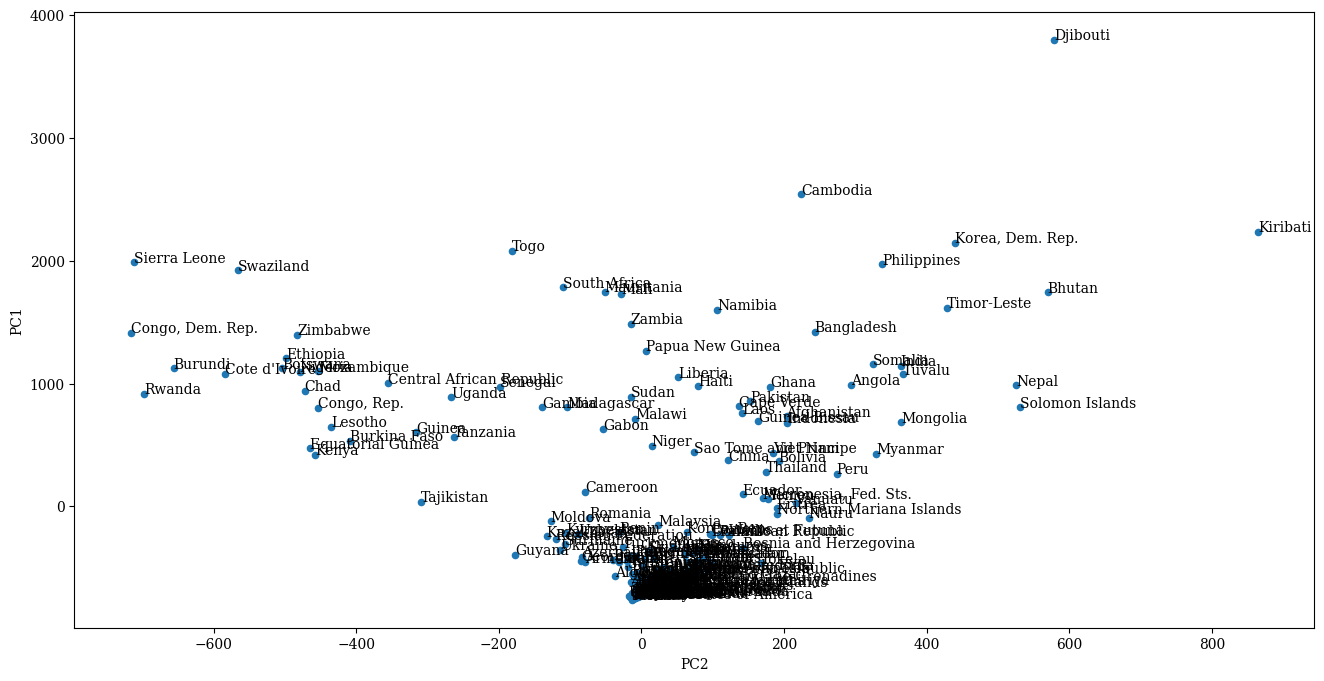

In [6]:
ax = existing_df_2d.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))
for i, country in enumerate(existing_df.index):
    ax.annotate(
        country,
       (existing_df_2d.iloc[i].PC2, existing_df_2d.iloc[i].PC1)
    )

## 4. 平均値の追加
特定の国のすべての年の平均値に比例した値にポイントサイズを設定して、バブルチャートを作成します。
まず、年ごとに国ごとのスケール変更された平均を含む新しい列を追加します。

In [7]:
from sklearn.preprocessing import normalize
existing_df_2d['country_mean'] = pd.Series(existing_df.mean(axis=1), index=existing_df_2d.index)
country_mean_max = existing_df_2d['country_mean'].max()
country_mean_min = existing_df_2d['country_mean'].min()
country_mean_scaled = (existing_df_2d.country_mean - country_mean_min) / country_mean_max
existing_df_2d['country_mean_scaled'] = pd.Series(country_mean_scaled,index=existing_df_2d.index)
existing_df_2d.head()

,PC1,PC2,country_mean,country_mean_scaled
country,,,,
Afghanistan,732.215864,203.381494,353.333333,0.329731
Albania,-613.296510,4.715978,36.944444,0.032420
Algeria,-569.303713,-36.837051,47.388889,0.042234
American Samoa,-717.082766,5.464696,12.277778,0.009240
Andorra,-661.802241,11.037736,25.277778,0.021457


## 次に国名を省略して平均値をプロットサイズとして表示してみる。

<Axes: xlabel='PC2', ylabel='PC1'>

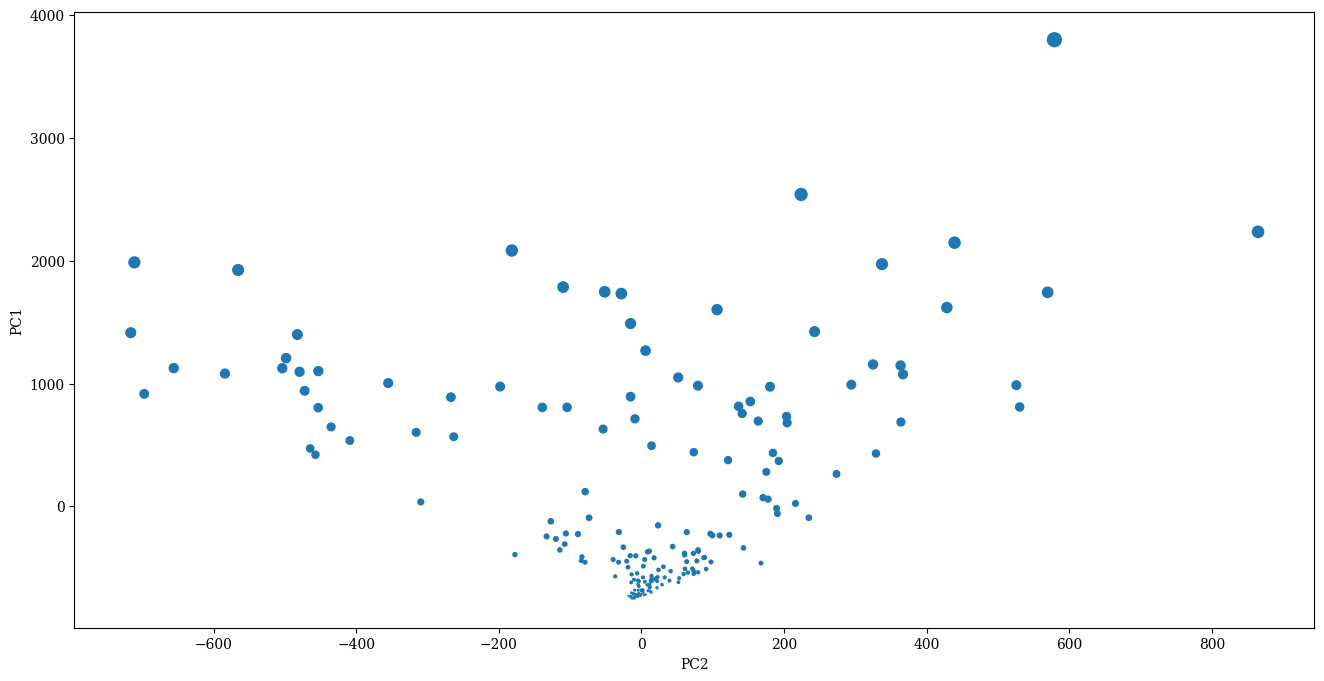

In [8]:
existing_df_2d.plot(kind='scatter', x='PC2', y='PC1', s=existing_df_2d['country_mean_scaled']*100, figsize=(16,8))

## 5. 合計値の追加
同様の考察を合計値で行います。



<Axes: xlabel='PC2', ylabel='PC1'>

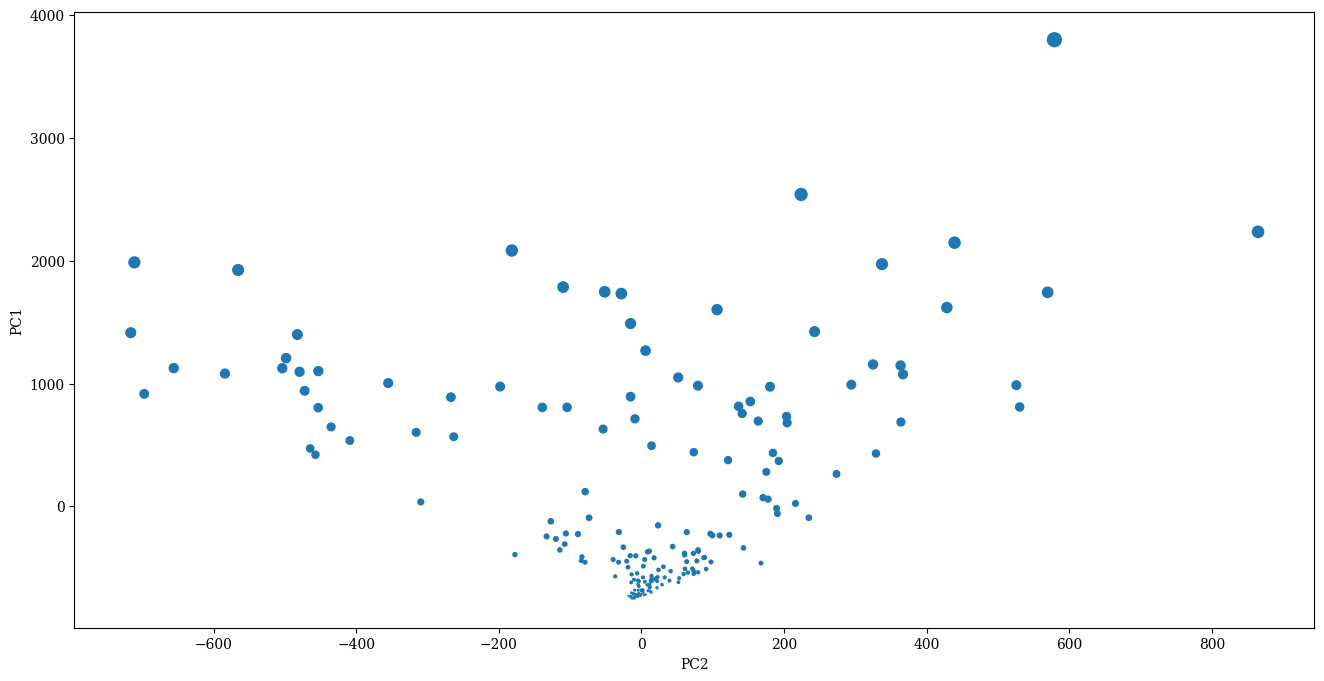

In [9]:
existing_df_2d['country_sum'] = pd.Series(existing_df.sum(axis=1), index=existing_df_2d.index)
country_sum_max = existing_df_2d['country_sum'].max()
country_sum_min = existing_df_2d['country_sum'].min()
country_sum_scaled = (existing_df_2d.country_sum-country_sum_min) / country_sum_max
existing_df_2d['country_sum_scaled'] = pd.Series(country_sum_scaled, index=existing_df_2d.index)
existing_df_2d.plot(kind='scatter', x='PC2', y='PC1', s=existing_df_2d['country_sum_scaled']*100, figsize=(16,8))

## 6. 変化量の関連付け
最後に、1990年から2007年の間のデータ変化サイズを関連づけます。
スケールされたバージョンで0に近い値は、スケール前バージョンでは負の値に紐づく。スケール後の値域は[0,1]

In [10]:
existing_df_2d['country_change'] = pd.Series(existing_df['2007']-existing_df['1990'], index=existing_df_2d.index)
country_change_max = existing_df_2d['country_change'].max()
country_change_min = existing_df_2d['country_change'].min()
country_change_scaled = (existing_df_2d['country_change'] - country_change_min)/ country_change_max
existing_df_2d['country_change_scaled'] = pd.Series(country_change_scaled, index=existing_df_2d.index)
existing_df_2d[['country_change','country_change_scaled']].head()

,country_change,country_change_scaled
country,,
Afghanistan,-198,0.850840
Albania,-20,1.224790
Algeria,11,1.289916
American Samoa,-37,1.189076
Andorra,-20,1.224790


プロットしてみる。

<Axes: xlabel='PC2', ylabel='PC1'>

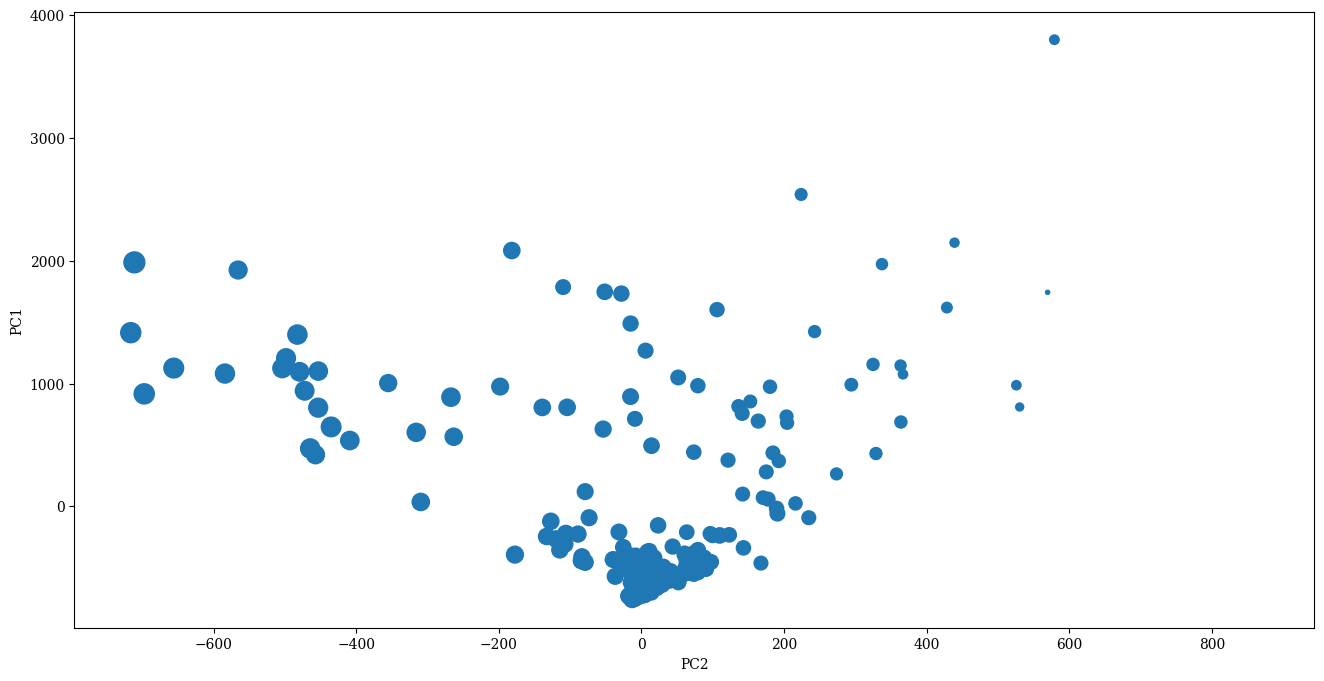

In [11]:
existing_df_2d.plot(kind='scatter', x='PC2', y='PC1', s=existing_df_2d['country_change_scaled']*100, figsize=(16,8))

## 7. 主成分分析の結果
主成分分析した結果をまとめると以下になります。

    ・PC1に割り当てたy軸に沿って最も変化が起きている。
    ・第一主成分で分散の92％を説明しており、第二主成分と98％を占める。
    ・チャートの一番上には、重要な国がプロット。ほとんどが先進国
    ・y軸の下方は疎な状態で開発途上国に属する。
    ・1990年から2007年の変化量を見ると、第2主成分の方向に沿ってほとんど変化し、
    　ケースの数の増量の差として表現されている。
↓

    ・第一主成分がデータの分散のほとんどを捉えているが
    ・1990年から2007年の範囲の合計に基づいた分散＝第二主成分は時間の経過で大きく変化している。

次に国の間の他の関係性を見ていきます。

## 8. k-means によるクラスタリング
次にk-meansクラスタリングを使用して、状況が年々どのように類似しているかに基づいて国をグループ化します。

    ・18の変数に基づいてデータをクラスター化し、
    ・データ内の隠れた関係を発見し、
    ・結核病に関する世界の状況をよりよく理解するために、クラスター割り当てを2Dチャートに色付けする。

sklearn を使用して、TBデータのクラスタリングを実行する。
クラスター数は5つとする。
クラスターラベルは clusters.labels_で返されるので、クラスター割り当てを
データフレームに格納する。

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit(existing_df)
existing_df_2d['cluster'] = pd.Series(clusters.labels_, index=existing_df_2d.index)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


プロットしてみる。

<ipython-input-13-21a4cfc14f88>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=existing_df_2d.cluster.astype(np.float),


<Axes: xlabel='PC2', ylabel='PC1'>

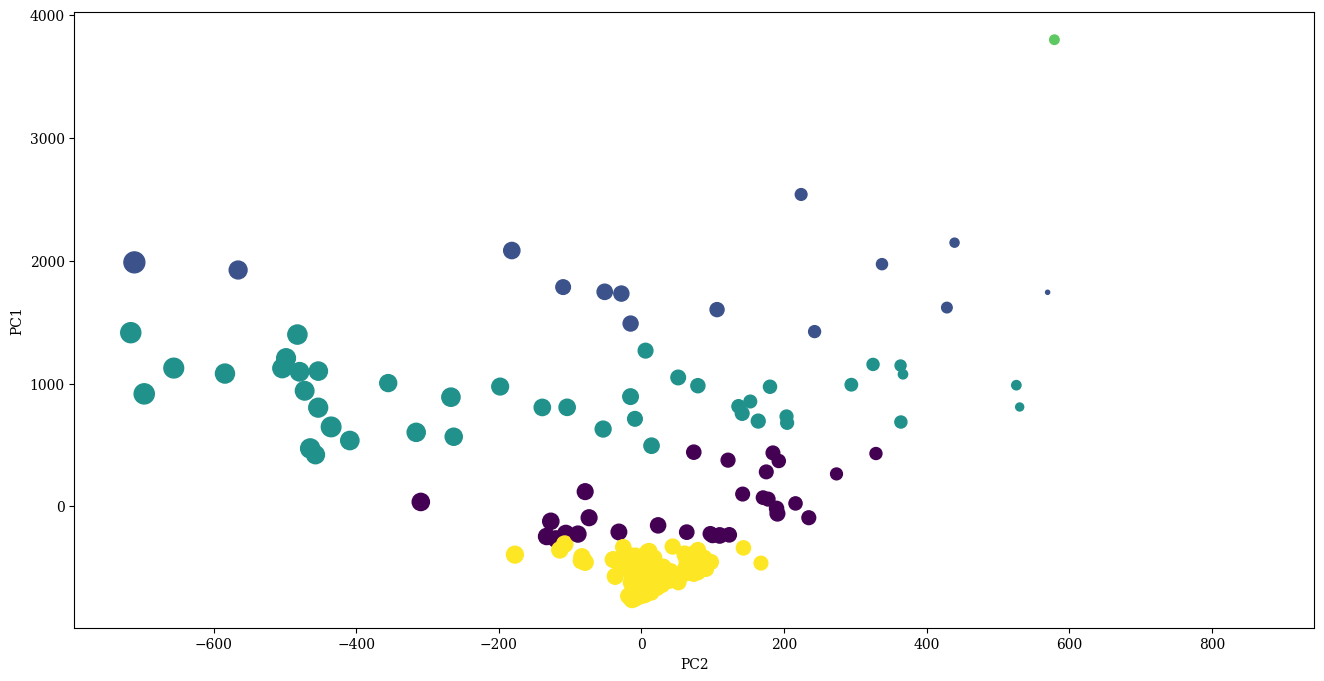

In [13]:
import numpy as np

existing_df_2d.plot(
        kind='scatter',
        x='PC2',y='PC1',
        c=existing_df_2d.cluster.astype(np.float),
        s=existing_df_2d['country_change_scaled']*100,
        figsize=(16,8))

## 9. クラスタリング結果の考察
各クラスタを分析するために、クラスタIDを含むデータフレームに列を追加しましょう。サブセット化に使用します。

### 9-1. クラスターのサンプル数の分布
クラスターの分布を確認します。

In [14]:
existing_df_2d['cluster'].value_counts()

4    119
2     43
0     29
1     15
3      1
Name: cluster, dtype: int64

## 9-2. クラスターの重心の変動確認
クラスターの重心の変動を確認します。

In [15]:
df = clusters.cluster_centers_
display(df)

array([[ 216.82758621,  222.20689655,  208.06896552,  210.10344828,
         205.65517241,  199.86206897,  191.44827586,  204.75862069,
         194.31034483,  189.13793103,  170.31034483,  163.10344828,
         168.03448276,  156.75862069,  151.89655172,  149.24137931,
         146.96551724,  138.62068966],
       [ 715.93333333,  702.8       ,  686.4       ,  669.8       ,
         654.2       ,  641.06666667,  618.4       ,  618.46666667,
         599.        ,  603.33333333,  612.73333333,  626.2       ,
         582.4       ,  577.2       ,  568.26666667,  571.46666667,
         567.4       ,  561.86666667],
       [ 371.53488372,  376.        ,  375.51162791,  376.18604651,
         377.23255814,  379.11627907,  373.06976744,  376.04651163,
         378.02325581,  396.48837209,  400.8372093 ,  405.6744186 ,
         413.25581395,  424.53488372,  417.97674419,  410.88372093,
         404.09302326,  403.53488372],
       [1485.        , 1477.        , 1463.        , 1442.        ,

重心の変動をプロットします。

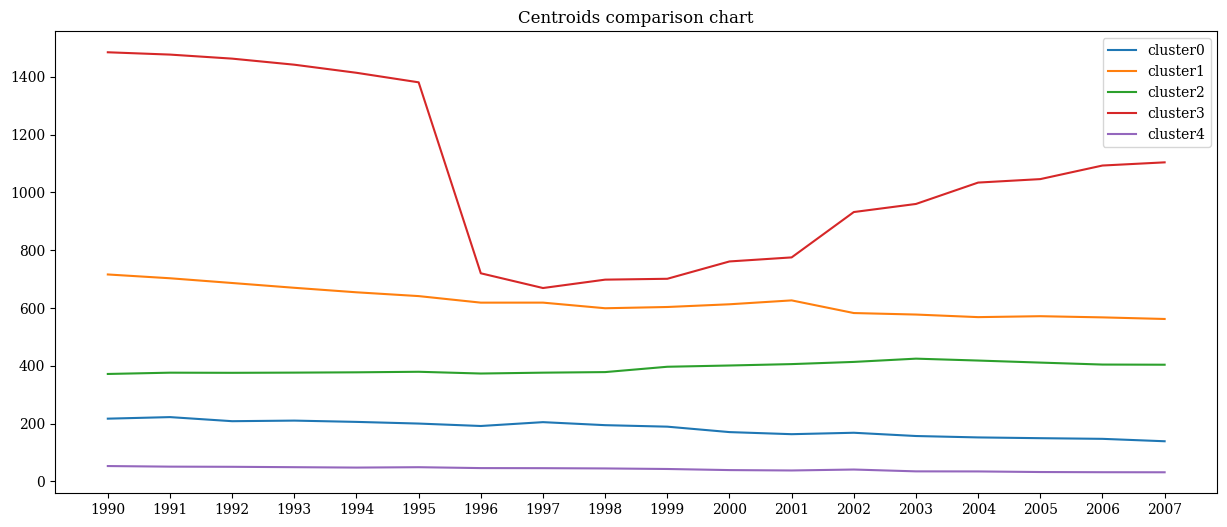

In [16]:
x = np.arange(1990, 2008)
fig, ax = plt.subplots()
for cl in range(0,5):
    ax.plot(x, np.array((df)[cl]), label='cluster'+str(cl))

plt.title('Centroids comparison chart')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.legend(loc='best')

## Cluster 1
クラスター1には51ヶ国が含まれる。

In [17]:
existing_df_2d[existing_df_2d['cluster']==0]

,PC1,PC2,country_mean,country_mean_scaled,country_sum,country_sum_scaled,country_change,country_change_scaled,cluster
country,,,,,,,,,
Benin,-208.237408,-31.658052,132.444444,0.122161,2384,0.122161,-5,1.256303,0
Bolivia,369.739970,192.500210,267.000000,0.248603,4806,0.248603,-179,0.890756,0
Cameroon,120.281096,-78.943508,210.388889,0.195406,3787,0.195406,7,1.281513,0
China,376.487336,121.359175,269.666667,0.251109,4854,0.251109,-133,0.987395,0
Comoros,-222.702045,96.540347,128.333333,0.118298,2310,0.118298,-105,1.046218,0
Dominican Republic,-236.204726,99.551198,125.111111,0.115270,2252,0.115270,-101,1.054622,0
Ecuador,100.474079,141.868942,204.222222,0.189611,3676,0.189611,-142,0.968487,0
Eritrea,-15.888644,189.401997,176.722222,0.163769,3181,0.163769,-111,1.033613,0
Kazakhstan,-244.686480,-133.007050,124.944444,0.115114,2249,0.115114,44,1.359244,0


重心の変動はこちら。

In [18]:
df[0]

array([216.82758621, 222.20689655, 208.06896552, 210.10344828,
       205.65517241, 199.86206897, 191.44827586, 204.75862069,
       194.31034483, 189.13793103, 170.31034483, 163.10344828,
       168.03448276, 156.75862069, 151.89655172, 149.24137931,
       146.96551724, 138.62068966])

    ・このクラスターには多くのアメリカ大陸の国と一部のヨーロッパ諸国が属する。
    ・一部の国はロシアやブラジルのように大きく豊か。
    ・患者数は減少傾向。



## Cluster 2
クラスター2には30ヶ国が含まれる。

In [19]:
existing_df_2d[existing_df_2d['cluster']==1]

,PC1,PC2,country_mean,country_mean_scaled,country_sum,country_sum_scaled,country_change,country_change_scaled,cluster
country,,,,,,,,,
Bangladesh,1422.800603,242.722083,515.444444,0.482067,9278,0.482067,-252,0.737395,1
Bhutan,1742.709249,569.448954,587.722222,0.549987,10579,0.549987,-561,0.088235,1
Cambodia,2538.953258,223.864004,778.611111,0.729366,14015,0.729366,-264,0.712185,1
"Korea, Dem. Rep.",2146.623299,438.945977,686.611111,0.642913,12359,0.642913,-400,0.426471,1
Kiribati,2234.809790,864.494075,702.888889,0.658209,12652,0.658209,-603,0.000000,1
Mali,1732.257902,-28.197847,589.500000,0.551658,10611,0.551658,-41,1.180672,1
Mauritania,1746.666128,-51.540677,594.333333,0.556199,10698,0.556199,-26,1.212185,1
Namibia,1601.720101,105.968321,555.000000,0.519238,9990,0.519238,-118,1.018908,1
Philippines,1971.702345,337.221038,644.666667,0.603498,11604,0.603498,-299,0.638655,1


重心の変動はこちら。

In [20]:
df[1]

array([715.93333333, 702.8       , 686.4       , 669.8       ,
       654.2       , 641.06666667, 618.4       , 618.46666667,
       599.        , 603.33333333, 612.73333333, 626.2       ,
       582.4       , 577.2       , 568.26666667, 571.46666667,
       567.4       , 561.86666667])

    ・このクラスターは症例数が年々増加している唯一のクラスター。
    ・症例数が最多の第三クラスターを追い越す勢い。
    →これらの各国は人道危機の中にあり、おそらくHIVのような他の感染症にかかっている。

## Cluster 3
クラスター3には16ヶ国が含まれる。

In [21]:
existing_df_2d[existing_df_2d['cluster']==2]

,PC1,PC2,country_mean,country_mean_scaled,country_sum,country_sum_scaled,country_change,country_change_scaled,cluster
country,,,,,,,,,
Afghanistan,732.215864,203.381494,353.333333,0.329731,6360,0.329731,-198,0.850840,2
Angola,990.536338,294.243725,413.444444,0.386218,7442,0.386218,-220,0.804622,2
Botswana,1124.623706,-503.640618,448.166667,0.418846,8067,0.418846,278,1.850840,2
Burkina Faso,536.374072,-408.919486,310.166667,0.289167,5583,0.289167,224,1.737395,2
Burundi,1125.814696,-655.801897,449.833333,0.420412,8097,0.420412,359,2.021008,2
Cape Verde,814.529926,136.122326,372.888889,0.348108,6712,0.348108,-169,0.911765,2
Central African Republic,1003.717739,-355.104319,419.833333,0.392221,7557,0.392221,107,1.491597,2
Chad,940.992223,-472.269062,406.444444,0.379640,7316,0.379640,246,1.783613,2
"Congo, Rep.",803.678138,-453.276487,375.277778,0.350352,6755,0.350352,276,1.846639,2


重心の変動はこちら。

In [22]:
df[2]

array([371.53488372, 376.        , 375.51162791, 376.18604651,
       377.23255814, 379.11627907, 373.06976744, 376.04651163,
       378.02325581, 396.48837209, 400.8372093 , 405.6744186 ,
       413.25581395, 424.53488372, 417.97674419, 410.88372093,
       404.09302326, 403.53488372])

    ・このクラスターは、症例数は徐々に減少しているが、毎年最も結核が多い国々。

## Cluster 4
クラスター4には20ヶ国が含まれる。

In [23]:
existing_df_2d[existing_df_2d['cluster']==3]

,PC1,PC2,country_mean,country_mean_scaled,country_sum,country_sum_scaled,country_change,country_change_scaled,cluster
country,,,,,,,,,
Djibouti,3798.447446,578.975277,1064.166667,0.997703,19155,0.997703,-381,0.466387,3


重心の変動はこちら。

In [24]:
df[3]

array([1485., 1477., 1463., 1442., 1414., 1381.,  720.,  669.,  698.,
        701.,  761.,  775.,  932.,  960., 1034., 1046., 1093., 1104.])

    ・インドや中国などが含まれ、症例が最も減少しているクラスター。

## Cluster 5
クラスター5には最大の90ヶ国が含まれる。

In [25]:
existing_df_2d[existing_df_2d['cluster']==4]

,PC1,PC2,country_mean,country_mean_scaled,country_sum,country_sum_scaled,country_change,country_change_scaled,cluster
country,,,,,,,,,
Albania,-613.296510,4.715978,36.944444,0.032420,665,0.032420,-20,1.224790,4
Algeria,-569.303713,-36.837051,47.388889,0.042234,853,0.042234,11,1.289916,4
American Samoa,-717.082766,5.464696,12.277778,0.009240,221,0.009240,-37,1.189076,4
Andorra,-661.802241,11.037736,25.277778,0.021457,455,0.021457,-20,1.224790,4
Anguilla,-618.891169,-14.502928,35.611111,0.031167,641,0.031167,-4,1.258403,4
...,...,...,...,...,...,...,...,...,...
Virgin Islands (U.S.),-682.788717,-0.402710,20.388889,0.016862,367,0.016862,-14,1.237395,4
United States of America,-749.043141,-9.326693,4.888889,0.002297,88,0.002297,-4,1.258403,4
Uruguay,-650.562152,-3.484980,28.055556,0.024067,505,0.024067,-12,1.241597,4


重心の変動はこちら。

In [26]:
df[4]

array([52.80672269, 50.7394958 , 50.18487395, 48.86554622, 47.51260504,
       48.81512605, 45.73109244, 45.44537815, 44.5210084 , 42.6302521 ,
       38.82352941, 37.49579832, 40.74789916, 34.42857143, 34.16806723,
       32.1092437 , 31.47058824, 31.24369748])

    ・結核発症数がもっとも少ないクラスター。
    ・ちなみに日本もここに属する。
    ・このクラスタは大きすぎて異質なものが含まれるので、おそらくさらなる洗練が必要。

## 10. 第二階層のクラスタリング
クラスター5の90カ国を再調整して、それを改良します。
クラスター5を持つ2つの異なるクラスタがあるかどうかを調べる。



In [35]:
# datasetcluster5_df　　クラスター5のみに絞ったデータセット
existing_df['cluster'] = pd.Series(clusters.labels_, index=existing_df.index)
datasetcluster5_df = existing_df[existing_df['cluster']==4]

# k-meansで二つに分類してみる
kmeans2 = KMeans(n_clusters=2)
cluster5_clustering = kmeans2.fit(datasetcluster5_df)

# 主成分1、主成分2と平均、合計の集計値のクラスター5のみの集計値
existing_cl5_df_2d = existing_df_2d[existing_df_2d['cluster'] == 4]

# 主成分1、主成分2と平均、合計の集計値のクラスター5のみの集計値
#  ＋ 二段階目のクラスタリング結果(cluster5=0,1)付与
df_label = pd.DataFrame(cluster5_clustering.labels_, index=existing_cl5_df_2d.index)
df_label.columns = ['cluster5']

datasetcluster5_df = pd.concat([existing_cl5_df_2d, df_label], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


クラスタリングの内訳を確認。クラスタ5-1->12ヶ国　クラスタ5-2->39ヶ国

In [36]:
datasetcluster5_df['cluster5'].value_counts()

0    74
1    45
Name: cluster5, dtype: int64

二段階目のクラスタリングしたさいの重心値を確認します。

In [37]:
# 二段階目のクラスタリングしたさいの重心値
df2 = cluster5_clustering.cluster_centers_
print(df2)

[[28.22972973 27.02702703 26.87837838 25.94594595 25.01351351 23.98648649
  22.93243243 22.28378378 21.01351351 19.90540541 18.55405405 18.25675676
  17.35135135 16.59459459 16.45945946 15.91891892 15.67567568 15.60810811
   4.        ]
 [93.22222222 89.73333333 88.51111111 86.55555556 84.51111111 89.64444444
  83.22222222 83.53333333 83.17777778 80.         72.15555556 69.13333333
  79.22222222 63.75555556 63.28888889 58.73333333 57.44444444 56.95555556
   4.        ]]


グラフ表示します。

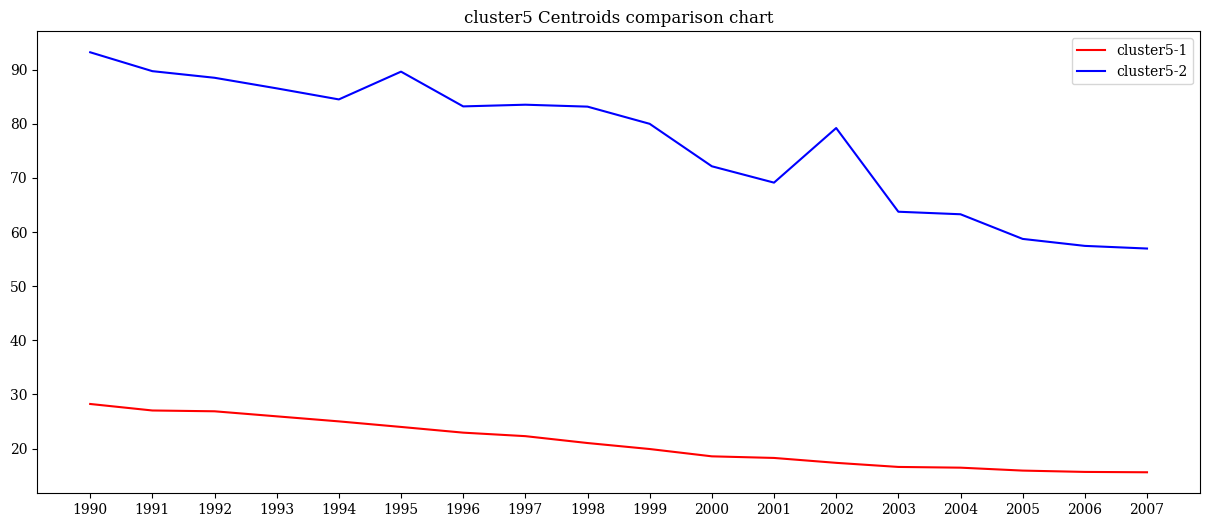

In [38]:
# 二段階目のクラスタリングしたさいの重心値のグラフ表示
x = np.arange(1990, 2008)
fig, ax = plt.subplots()

ax.plot(x, df2[0,0:18], label='cluster5-1', color='r')
ax.plot(x, df2[1,0:18], label='cluster5-2', color='b')
ax.set_xticks(x)
ax.set_xticklabels(x)
plt.title('cluster5 Centroids comparison chart')
plt.legend(loc='best')

cluster5-1 の国データ

In [39]:
print(datasetcluster5_df[datasetcluster5_df['cluster5']==0])

                                 PC1        PC2  country_mean  \
country                                                         
Albania                  -613.296510   4.715978     36.944444   
Algeria                  -569.303713 -36.837051     47.388889   
American Samoa           -717.082766   5.464696     12.277778   
Andorra                  -661.802241  11.037736     25.277778   
Anguilla                 -618.891169 -14.502928     35.611111   
...                              ...        ...           ...   
Virgin Islands (U.S.)    -682.788717  -0.402710     20.388889   
United States of America -749.043141  -9.326693      4.888889   
Uruguay                  -650.562152  -3.484980     28.055556   
Venezuela                -596.326691 -10.524193     40.888889   
West Bank and Gaza       -585.225414  14.463482     43.388889   

                          country_mean_scaled  country_sum  \
country                                                      
Albania                       

cluster5-2 の国データ

In [40]:
print(datasetcluster5_df[datasetcluster5_df['cluster5']==1])

                               PC1         PC2  country_mean  \
country                                                        
Argentina              -508.244158   61.039700     61.222222   
Armenia                -454.552060  -78.986374     74.944444   
Azerbaijan             -410.215266  -83.510757     85.611111   
Bahamas                -553.237930  -13.787740     51.111111   
Bahrain                -443.480516   77.585555     76.388889   
Belarus                -432.631571  -39.693354     80.333333   
Bosnia and Herzegovina -337.633139  142.997336    100.944444   
Brazil                 -394.477560   60.513236     88.055556   
Brunei Darussalam      -418.462708   17.711361     82.888889   
Bulgaria               -544.874902   -6.043780     53.333333   
Colombia               -491.294650   30.672246     65.388889   
Croatia                -382.173929   72.910116     90.944444   
El Salvador            -417.182352   87.295450     82.388889   
Estonia                -486.642717    2.

    ・5−1のクラスターは相対的に結核発症数が多いグループ。全体として大きく減少している。
    ・5-2のクラスターは相対的に結核発症数が少ないグループ。
    ・ちなみに日本は5−1のクラスターに属する。

11. 結論
PCAとk-meansクラスタリングに関して

    ・PCA

    まず18年間の症例数の増減に基づいて、2次元空間にすべての国の分布をプロットした。
    それにより、症例の総数が主成分、時間の変化の割合が第2の成分で表現した。

    ・k-means クラスタリング

    次に、k-meansクラスタリングを使用して、各年のケース数がどれほど類似しているかに
    よって国をグループ化した。

時間の経過に伴ってほとんどの国がどのように改善したかが見て取れるが、
症例数を増やしている疾病の蔓延率の高い国のグループも発見した。